In [4]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

!pip -q install -U tf-keras ampligraph

import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("tf.keras module:", tf.keras.__name__)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.3/178.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 842.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━

## Установка зависимостей



In [5]:
!pip -q install ampligraph rdflib pandas numpy scikit-learn matplotlib seaborn adjustText

## Импорты


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdflib import Graph, Namespace, RDF, URIRef

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

try:
    from ampligraph.evaluation import train_test_split_no_unseen, mr_score, mrr_score, hits_at_n_score
except ImportError:
    from ampligraph.compat import train_test_split_no_unseen, mr_score, mrr_score, hits_at_n_score

try:
    from ampligraph.compat import evaluate_performance
except ImportError:
    from ampligraph.evaluation import evaluate_performance

from ampligraph.latent_features import ScoringBasedEmbeddingModel

## Загрузка графа



In [20]:
try:
    from google.colab import files
    uploaded = files.upload()
    KG_TTL = next(iter(uploaded.keys()))
except Exception:
    KG_TTL = "terraria_kg_result_skolem.ttl"

print("KG_TTL =", KG_TTL)

Saving terraria_kg_result_skolem.ttl to terraria_kg_result_skolem (1).ttl
KG_TTL = terraria_kg_result_skolem (1).ttl


## Парсим ttl в rdf и вытаскиваем триплеты



In [21]:
BASE = "http://example.org/terraria#"
terr = Namespace(BASE)

g = Graph()
g.parse(KG_TTL, format="turtle")
print("Triples in RDF:", len(g))

def short(u):
    s = str(u)
    if "#" in s:
        return s.split("#")[-1]
    return s.rsplit("/", 1)[-1]

triples = []
for s,p,o in g:
    if isinstance(s, URIRef) and isinstance(o, URIRef) and isinstance(p, URIRef):
        triples.append((short(s), short(p), short(o)))

triples_df = pd.DataFrame(triples, columns=["subject","predicate","object"]).drop_duplicates()
print("Triples used for embeddings:", len(triples_df))
print("Entities:", pd.unique(triples_df[["subject","object"]].values.ravel()).size)
print("Relations:", triples_df["predicate"].nunique())

triples_df.head(10)

Triples in RDF: 21950
Triples used for embeddings: 15336
Entities: 6216
Relations: 20


,subject,predicate,object
0,RC_Yellow_and_Black_Dye_Yellow_Dye,type,RecipeComponent
1,Recipe_Copper_Axe_,produces,Copper_Axe
2,RC_Chlorophyte_Mask_Chlorophyte_Bar,usesItem,Chlorophyte_Bar
3,Recipe_Sword_Rack_,produces,Sword_Rack
4,Recipe_Nebula_Fragment_Block_,hasComponent,RC_Nebula_Fragment_Block_Stone_Block
5,Recipe_Silver_Watch_,type,Recipe
6,Recipe_Star_in_a_Bottle_,hasComponent,RC_Star_in_a_Bottle_Fallen_Star
7,Recipe_Silver_Coin_,hasComponent,RC_Silver_Coin_Gold_Coin
8,RC_Shadewood_Dresser_Shadewood,type,RecipeComponent
9,Cactus_Sofa,type,Item


## Разделение на тестовую и обучающую выборки


In [22]:
X = triples_df[["subject","predicate","object"]].values

X_train, X_test = train_test_split_no_unseen(X, test_size=0.10, seed=0)

print("Train set size:", X_train.shape)
print("Test  set size:", X_test.shape)

Train set size: (13803, 3)
Test  set size: (1533, 3)


## Обучаем модель KG embeddings


In [23]:
model = ScoringBasedEmbeddingModel(
    k=200,
    eta=50,
    scoring_type="ComplEx",
    seed=0
)

model.compile(optimizer="adam", loss="multiclass_nll")

history = model.fit(
    X_train,
    batch_size=1024,
    epochs=20,
    verbose=True
)


Epoch 1/20
15/15 [==============================] - 15s 1s/step - loss: 3876.5454
Epoch 2/20
15/15 [==============================] - 14s 917ms/step - loss: 3875.3997
Epoch 3/20
15/15 [==============================] - 14s 921ms/step - loss: 3873.6179
Epoch 4/20
15/15 [==============================] - 14s 953ms/step - loss: 3870.2539
Epoch 5/20
15/15 [==============================] - 14s 949ms/step - loss: 3863.9709
Epoch 6/20
15/15 [==============================] - 14s 927ms/step - loss: 3852.9958
Epoch 7/20
15/15 [==============================] - 14s 921ms/step - loss: 3835.2253
Epoch 8/20
15/15 [==============================] - 14s 928ms/step - loss: 3808.4839
Epoch 9/20
15/15 [==============================] - 14s 932ms/step - loss: 3770.8357
Epoch 10/20
15/15 [==============================] - 14s 932ms/step - loss: 3721.0488
Epoch 11/20
15/15 [==============================] - 14s 938ms/step - loss: 3658.9626
Epoch 12/20
15/15 [==============================] - 14s 914ms/ste

## Оценка качества (MR, MRR, Hits@K)


In [24]:
import inspect

sig = inspect.signature(evaluate_performance)
if "use_default_protocol" in sig.parameters:
    ranks = evaluate_performance(
        X_test,
        model=model,
        corrupt_side="s+o",
        use_default_protocol=True,
        verbose=True
    )
else:
    ranks = evaluate_performance(
        X_test,
        model=model,
        corrupt_side="s,o",
        verbose=True,
        batch_size=64
    )

print("MRR:", round(mrr_score(ranks), 4))
print("MR :", round(mr_score(ranks), 4))
print("Hits@10:", round(hits_at_n_score(ranks, n=10), 4))
print("Hits@3 :", round(hits_at_n_score(ranks, n=3), 4))
print("Hits@1 :", round(hits_at_n_score(ranks, n=1), 4))

25/25 [==============================] - 24s 975ms/step
MRR: 0.0874
MR : 1696.0646
Hits@10: 0.2019
Hits@3 : 0.1582
Hits@1 : 0.0


## Кластеризация и визуализация: оружия

Берём только те сущности, которые:
- имеют связь `hasDamageType`
- и находятся в обученной модели


In [25]:
weapons = set()
weapon_type = {}

for s,p,o in g:
    if isinstance(s, URIRef) and isinstance(p, URIRef) and isinstance(o, URIRef):
        if short(p) == "hasDamageType":
            ws = short(s)
            weapons.add(ws)
            weapon_type[ws] = short(o)

weapons = sorted(list(weapons))
print("Weapons with hasDamageType:", len(weapons))

emb = model.get_embeddings(weapons)
mask = ~np.isnan(emb).any(axis=1)
weapons_ok = [w for w,m in zip(weapons, mask) if m]
emb_ok = emb[mask]

labels = [weapon_type[w] for w in weapons_ok]
print("Weapons in model:", len(weapons_ok))

pca = PCA(n_components=2, random_state=0)
xy = pca.fit_transform(emb_ok)

df_vis = pd.DataFrame({
    "weapon": weapons_ok,
    "type": labels,
    "x": xy[:,0],
    "y": xy[:,1],
})

k = len(sorted(set(labels))) if labels else 4
k = max(2, min(k, 6))
km = KMeans(n_clusters=k, n_init=30, random_state=0)
df_vis["cluster"] = km.fit_predict(emb_ok)

df_vis.head()

Weapons with hasDamageType: 396
Weapons in model: 396


,weapon,type,x,y,cluster
0,Abigail_s_Flower,Melee,0.999162,-0.154635,0
1,Adamantite_Glaive,Melee,0.310495,-0.947205,0
2,Adamantite_Repeater,Melee,0.055434,-0.825963,0
3,Adamantite_Sword,Melee,-0.954470,-1.069009,1
4,Aerial_Bane,Melee,-0.517924,0.608051,1


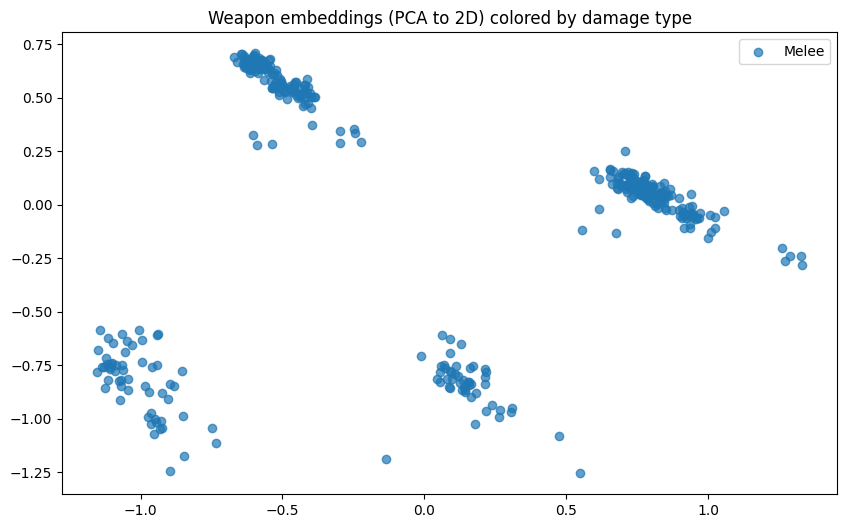

In [26]:
plt.figure(figsize=(10,6))
for t in sorted(df_vis["type"].unique()):
    sub = df_vis[df_vis["type"]==t]
    plt.scatter(sub["x"], sub["y"], label=t, alpha=0.7)
plt.title("Weapon embeddings (PCA to 2D) colored by damage type")
plt.legend()
plt.show()

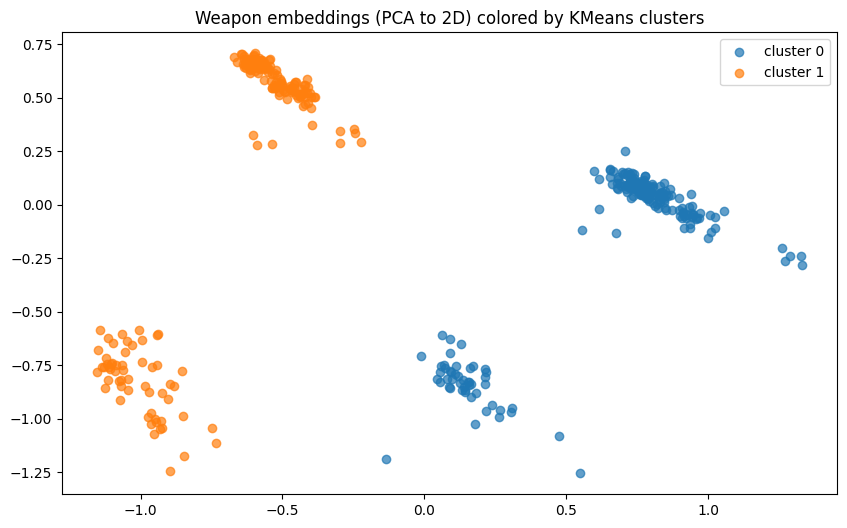

In [27]:
plt.figure(figsize=(10,6))
for c in sorted(df_vis["cluster"].unique()):
    sub = df_vis[df_vis["cluster"]==c]
    plt.scatter(sub["x"], sub["y"], label=f"cluster {c}", alpha=0.7)
plt.title("Weapon embeddings (PCA to 2D) colored by KMeans clusters")
plt.legend()
plt.show()

## Классификация: предсказываем тип урона оружия по его эмбеддингу

Задача: по вектору оружия предсказать `hasDamageType`.


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import numpy as np

X_feat = emb_ok
y = np.array(labels)

cnt = Counter(y)
print("Label counts:", dict(cnt))

if len(cnt) < 2:
    only = next(iter(cnt)) if len(cnt) else None
else:
    keep = np.array([cnt[yy] >= 2 for yy in y], dtype=bool)
    X2 = X_feat[keep]
    y2 = y[keep]

    cnt2 = Counter(y2)
    print("After filtering singletons:", dict(cnt2))

    strat = y2 if (len(cnt2) >= 2 and min(cnt2.values()) >= 2) else None
    X_tr, X_te, y_tr, y_te = train_test_split(
        X2, y2, test_size=0.25, random_state=0, stratify=strat
    )

    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_tr, y_tr)

    pred = clf.predict(X_te)
    print("Accuracy:", round(accuracy_score(y_te, pred), 4))
    print(classification_report(y_te, pred))

Label counts: {np.str_('Melee'): 396}


## Link prediction: какой `hasDamageType` наиболее вероятен для выбранного оружия

Мы перебираем кандидатов типов урона и ранжируем по score модели.


In [30]:
weapons_ok[:10]

['Abigail_s_Flower',
 'Adamantite_Glaive',
 'Adamantite_Repeater',
 'Adamantite_Sword',
 'Aerial_Bane',
 'Ale_Tosser',
 'Amarok',
 'Amazon',
 'Amber_Staff',
 'Amethyst_Staff']

In [31]:
weapon = weapons_ok[0]
damage_types = sorted(list(set(labels)))
candidates = np.array([[weapon, "hasDamageType", dt] for dt in damage_types], dtype=object)

scores = model.predict(candidates)
ranked = sorted(zip(damage_types, scores), key=lambda x: x[1], reverse=True)

print("Weapon:", weapon)
print("Top predicted damage types:")
for dt, sc in ranked[:10]:
    print(f"  {dt:10s}  score={sc:.4f}")

Weapon: Abigail_s_Flower
Top predicted damage types:
  Melee       score=4.3326
